In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, add, Cropping2D, ReLU, BatchNormalization, Lambda
from tensorflow.keras.layers import Concatenate, Reshape, MaxPooling1D, Cropping1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import activations

import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)
#tf.keras.backend.set_floatx('float16')

In [2]:
height_x = 120
width_x = 133
channels = 3
shape_x = (height_x, width_x, channels)
width_y = 27
shape_y = (height_x, width_y, channels)
data_num = 1
data_dir = f"../../datasets/dataset_0{data_num}/quarter/"

activation = 'relu'
regularizer = regularizers.l1(1e-9)
dropout_ratio = 0.25
batch_size = 16
epochs = 25
learning_rate = 1e-4

workers = 4

In [3]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, batch_size=4,
                    n_channels=1, n_classes=1, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'X', filename)
                image_x = pyplot.imread(filepath)
                filepath = os.path.join(data_dir+'Y', filename)
                image_y = pyplot.imread(filepath)
                if len(image_y.shape) > 2 and len(image_x.shape) > 2:
                    Y.append(image_y)
                    X.append(image_x)
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)
        return X, Y

## Autoencoder v1

In [4]:
kernel = (2,4)
padding = 'same'
max_strides = (2,4)
max_padding = 'valid'
kernel_decoder = (3,3)

input_x = Input(shape=shape_x)

l1_1 = Conv2D(64, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(input_x)
l1_2 = Conv2D(64, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l1_1)
l1_3 = MaxPooling2D(padding=max_padding, strides=max_strides)(l1_2)
l2_1 = Conv2D(128, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l1_3)
l2_2 = Conv2D(128, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l2_1)
l2_3 = MaxPooling2D(padding=max_padding, strides=max_strides)(l2_2)
l3_1 = Conv2D(256, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l2_3)

l4_1 = UpSampling2D()(l3_1)
l4_2 = Cropping2D(cropping=((0,0), (0, 2)))(l4_1)
l4_3 = Conv2D(128, kernel_decoder, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l4_2)
l4_4 = Conv2D(128, kernel_decoder, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l4_3)
l5_1 = UpSampling2D()(l4_4)
l5_2 = Cropping2D(cropping=((0,0), (0, 1)))(l5_1)
l5_3 = Conv2D(64, kernel_decoder, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l5_2)
l5_4 = Conv2D(64, kernel_decoder, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l5_3)

l6 = Conv2D(3, (7,7), padding=padding, activation=activation,
            activity_regularizer=regularizer)(l5_4)
autoencoder = Model(input_x, l6)
autoencoder.summary()
print(shape_y)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 133, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 133, 64)      1600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 133, 64)      32832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 33, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 33, 128)       65664     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 33, 128)       131200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 8, 128)        0     

## Autoencoder v2

In [4]:
kernel = (2,4)
print(tuple([x*2 for x in kernel]))
padding = 'same'
max_strides = (2,4)
max_padding = 'valid'
kernel_decoder = (3,3)

input_x = Input(shape=shape_x)
l1_1 = Conv2D(64, tuple([x*2 for x in kernel]), padding=padding, activation=activation,
            activity_regularizer=regularizer)(input_x)
l1_2 = Conv2D(64, tuple([x*2 for x in kernel]), padding=padding, activation=activation,
            activity_regularizer=regularizer)(l1_1)
l1_3 = MaxPooling2D(padding=max_padding, strides=max_strides)(l1_2)
l2_1 = Conv2D(128, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l1_3)
l2_2 = Conv2D(128, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l2_1)
l2_3 = MaxPooling2D(padding=max_padding, strides=max_strides)(l2_2)
l3_1 = Conv2D(256, (1,2), padding=padding, activation=activation,
            activity_regularizer=regularizer)(l2_3)

l4_1 = UpSampling2D()(l3_1)
l4_2 = Cropping2D(cropping=((0,0), (0, 2)))(l4_1)
l4_3 = Conv2D(128, kernel_decoder, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l4_2)
l4_4 = Conv2D(128, kernel_decoder, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l4_3)
l5_1 = UpSampling2D()(l4_4)
l5_2 = Cropping2D(cropping=((0,0), (0, 1)))(l5_1)
l5_3 = Conv2D(64, kernel_decoder, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l5_2)
l5_4 = Conv2D(64, kernel_decoder, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l5_3)

l6 = Conv2D(3, (7,7), padding=padding, activation=activation,
            activity_regularizer=regularizer)(l5_4)

autoencoder = Model(input_x, l6)
autoencoder.summary()

(4, 8)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 133, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 133, 64)      6208      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 133, 64)      131136    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 33, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 33, 128)       65664     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 33, 128)       131200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 8, 128)       

## Resnet

In [4]:
n_blocks = 16
filters = 64
momentum = 0.8

def residual_block(input, kernels, momentum, skip=True):
    x = Conv2D(kernels, kernel_size=3, strides=1, padding='same')(input)
    x = BatchNormalization(momentum=momentum)(x)
    x = ReLU()(x)
    x = Conv2D(kernels, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization(momentum=momentum)(x)
    if skip:
        x = add([input, x])
    return ReLU()(x)

input_x = Input(shape=shape_x)
x_start = Conv2D(filters, kernel_size=9, strides=1, padding='same')(input_x)
x_start = ReLU()(x_start)
x_start = MaxPooling2D(padding='same', strides=(1,2))(x_start)
x_start = Cropping2D(((0,0), (3,0)))(x_start)

r = residual_block(x_start, filters, momentum)
for i in range(0, 2):
    for j in range(0, 3):
        if i==0:    j = j+1
        skip = False if j == 0 else True
        r =residual_block(r, filters * (2**i), momentum, skip=skip)

x = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
x = BatchNormalization(momentum=momentum)(x)
x = add([x, x_start])
x = MaxPooling2D(padding='same', strides=(1,2))(x)

x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization(momentum=momentum)(x)
x = ReLU()(x)
x = Cropping2D(((0,0),(5,0)))(x)

x = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)

autoencoder = Model(input_x, x)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 133, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 120, 133, 64) 15616       input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 120, 133, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 120, 67, 64)  0           re_lu[0][0]                      
______________________________________________________________________________________________

## Autoencoder Blocks

In [4]:
activation='relu'
activation_last = 'tanh'
regularizer=None
regularizer_last=None
padding='same'
padding_last='same'
filters=64
filters_last=64
max_pool_last = True

input_x = Input(shape=shape_x)
x = Cropping2D(((0,0),(13,0)))(input_x)

# Big Block
b1 = Lambda(lambda x:x[:,:60,:60,:])(x)
b1 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b1)
b1 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b1)
b1 = MaxPooling2D()(b1)

b2 = Lambda(lambda x:x[:,60:,:60,:])(x)
b2 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b2)
b2 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b2)
b2 = MaxPooling2D()(b2)

# Mid Block 1
b1_1 = Lambda(lambda x:x[:,:30,60:90,:])(x)
b1_1 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b1_1)
b1_1 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b1_1)
b1_1 = Concatenate(axis=3)([b1_1, b1])
b1_1 = MaxPooling2D()(b1_1)

b1_2 = Lambda(lambda x:x[:,:30,90:120,:])(x)
b1_2 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b1_2)
b1_2 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b1_2)
b1_2 = Concatenate(axis=3)([b1_2, b1])
b1_2 = MaxPooling2D()(b1_2)

b1_3 = Lambda(lambda x:x[:,30:60,60:90,:])(x)
b1_3 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b1_3)
b1_3 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b1_3)
b1_3 = Concatenate(axis=3)([b1_3, b1])
b1_3 = MaxPooling2D()(b1_3)

b1_4 = Lambda(lambda x:x[:,30:60,90:120,:])(x)
b1_4 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b1_4)
b1_4 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b1_4)
b1_4 = Concatenate(axis=3)([b1_4, b1])
b1_4 = MaxPooling2D()(b1_4)

# Mid Block 2
b2_1 = Lambda(lambda x:x[:,60:90,60:90,:])(x)
b2_1 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b2_1)
b2_1 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b2_1)
b2_1 = Concatenate(axis=3)([b2_1, b2])
b2_1 = MaxPooling2D()(b2_1)

b2_2 = Lambda(lambda x:x[:,60:90,90:120,:])(x)
b2_2 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b2_2)
b2_2 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b2_2)
b2_2 = Concatenate(axis=3)([b2_2, b2])
b2_2 = MaxPooling2D()(b2_2)

b2_3 = Lambda(lambda x:x[:,90:120,60:90,:])(x)
b2_3 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b2_3)
b2_3 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b2_3)
b2_3 = Concatenate(axis=3)([b2_3, b2])
b2_3 = MaxPooling2D()(b2_3)

b2_4 = Lambda(lambda x:x[:,90:120,90:120,:])(x)
b2_4 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b2_4)
b2_4 = Conv2D(filters, kernel_size=3, padding=padding, activation=activation,
            activity_regularizer=regularizer)(b2_4)
b2_4 = Concatenate(axis=3)([b2_4, b2])
b2_4 = MaxPooling2D()(b2_4)

# Small Block 1
b1_1_1 = Concatenate(axis=3)([b1_1, b1_2])
b1_1_1 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b1_1_1)
if max_pool_last:
    b1_1_1 = MaxPooling2D(pool_size=(1,1))(b1_1_1)

b1_1_2 = Concatenate(axis=3)([b1_1, b1_2])
b1_1_2 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b1_1_2)
if max_pool_last:
    b1_1_2 = MaxPooling2D(pool_size=(1,1))(b1_1_2)

b1_1_3 = Concatenate(axis=3)([b1_1, b1_2])
b1_1_3 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b1_1_3)
if max_pool_last:
    b1_1_3 = MaxPooling2D(pool_size=(1,1))(b1_1_3)

b1_1_4 = Concatenate(axis=3)([b1_1, b1_2])
b1_1_4 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b1_1_4)
if max_pool_last:
    b1_1_4 = MaxPooling2D(pool_size=(1,1))(b1_1_4)

# Small Block 2
b1_2_1 = Concatenate(axis=3)([b1_3, b1_4])
b1_2_1 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b1_2_1)
if max_pool_last:
    b1_2_1 = MaxPooling2D(pool_size=(1,1))(b1_2_1)

b1_2_2 = Concatenate(axis=3)([b1_3, b1_4])
b1_2_2 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b1_2_2)
if max_pool_last:
    b1_2_2 = MaxPooling2D(pool_size=(1,1))(b1_2_2)

b1_2_3 = Concatenate(axis=3)([b1_3, b1_4])
b1_2_3 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b1_2_3)
if max_pool_last:
    b1_2_3 = MaxPooling2D(pool_size=(1,1))(b1_2_3)

b1_2_4 = Concatenate(axis=3)([b1_3, b1_4])
b1_2_4 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b1_2_4)
if max_pool_last:
    b1_2_4 = MaxPooling2D(pool_size=(1,1))(b1_2_4)

# Small Block 3
b2_1_1 = Concatenate(axis=3)([b2_1, b2_2])
b2_1_1 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b2_1_1)
if max_pool_last:
    b2_1_1 = MaxPooling2D(pool_size=(1,1))(b2_1_1)

b2_1_2 = Concatenate(axis=3)([b2_1, b2_2])
b2_1_2 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b2_1_2)
if max_pool_last:
    b2_1_2 = MaxPooling2D(pool_size=(1,1))(b2_1_2)

b2_1_3 = Concatenate(axis=3)([b2_1, b2_2])
b2_1_3 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b2_1_3)
if max_pool_last:
    b2_1_3 = MaxPooling2D(pool_size=(1,1))(b2_1_3)

b2_1_4 = Concatenate(axis=3)([b2_1, b2_2])
b2_1_4 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b2_1_4)
if max_pool_last:
    b2_1_4 = MaxPooling2D(pool_size=(1,1))(b2_1_4)

# Small Block 4
b2_2_1 = Concatenate(axis=3)([b2_3, b2_4])
b2_2_1 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b2_2_1)
if max_pool_last:
    b2_2_1 = MaxPooling2D(pool_size=(1,1))(b2_2_1)

b2_2_2 = Concatenate(axis=3)([b2_3, b2_4])
b2_2_2 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b2_2_2)
if max_pool_last:
    b2_2_2 = MaxPooling2D(pool_size=(1,1))(b2_2_2)

b2_2_3 = Concatenate(axis=3)([b2_3, b2_4])
b2_2_3 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b2_2_3)
if max_pool_last:
    b2_2_3 = MaxPooling2D(pool_size=(1,1))(b2_2_3)

b2_2_4 = Concatenate(axis=3)([b2_3, b2_4])
b2_2_4 = Conv2D(filters_last, (3,3), padding=padding_last, activation=activation_last, activity_regularizer=regularizer_last)(b2_2_4)
if max_pool_last:
    b2_2_4 = MaxPooling2D(pool_size=(1,1))(b2_2_4)

# Concate Small 1
cat1_1_12 = Concatenate(axis=2)([b1_1_1, b1_1_2])
cat1_1_12 = Conv2D(filters_last//2, (3,3), padding=padding_last, activation=activation_last,
                    activity_regularizer=regularizer_last)(cat1_1_12)
cat1_1_34 = Concatenate(axis=2)([b1_1_3, b1_1_4])
cat1_1_34 = Conv2D(filters_last//2, (3,3), padding=padding_last, activation=activation_last,
                    activity_regularizer=regularizer_last)(cat1_1_34)
cat1 = Concatenate(axis=1)([cat1_1_12, cat1_1_34])
cat1 = Conv2D(filters_last//4, (3,3), padding=padding_last, activation=activation_last,
                    activity_regularizer=regularizer_last)(cat1)

# Concate Small 2
cat1_2_12 = Concatenate(axis=2)([b1_2_1, b1_2_2])
cat1_2_12 = Conv2D(filters_last//2, (3,3), padding=padding_last, activation=activation_last,
                    activity_regularizer=regularizer_last)(cat1_2_12)
cat1_2_34 = Concatenate(axis=2)([b1_2_3, b1_2_4])
cat1_2_34 = Conv2D(filters_last//2, (3,3), padding=padding_last, activation=activation_last,
                    activity_regularizer=regularizer_last)(cat1_2_34)
cat2 = Concatenate(axis=1)([cat1_2_12, cat1_2_34])
cat2 = Conv2D(filters_last//4, (3,3), padding=padding_last, activation=activation_last,
                    activity_regularizer=regularizer_last)(cat2)

# Concate Small 3
cat2_1_12 = Concatenate(axis=2)([b2_1_1, b2_1_2])
cat2_1_12 = Conv2D(filters_last//2, (3,3), padding=padding_last, activation=activation_last,
                    activity_regularizer=regularizer_last)(cat2_1_12)
cat2_1_34 = Concatenate(axis=2)([b2_1_3, b2_1_4])
cat2_1_34 = Conv2D(filters_last//2, (3,3), padding=padding_last, activation=activation_last,
                    activity_regularizer=regularizer_last)(cat2_1_34)
cat3 = Concatenate(axis=1)([cat2_1_12, cat2_1_34])
cat3 = Conv2D(filters_last//4, (3,3), padding=padding_last, activation=activation_last,
                    activity_regularizer=regularizer_last)(cat3)

# Concate Small 3
cat2_2_12 = Concatenate(axis=2)([b2_2_1, b2_2_2])
cat2_2_12 = Conv2D(filters_last//2, (3,3), padding=padding_last, activation=activation_last,
                    activity_regularizer=regularizer_last)(cat2_2_12)
cat2_2_34 = Concatenate(axis=2)([b2_2_3, b2_2_4])
cat2_2_34 = Conv2D(filters_last//2, (3,3), padding=padding_last, activation=activation_last,
                    activity_regularizer=regularizer_last)(cat2_2_34)
cat4 = Concatenate(axis=1)([cat2_2_12, cat2_2_34])
cat4 = Conv2D(filters_last//4, (3,3), padding=padding_last, activation=activation_last,
                    activity_regularizer=regularizer_last)(cat4)

# Output
output = Concatenate(axis=1)([cat1, cat2, cat3, cat4])
output = Cropping2D(((0,0),(0,3)))(output)
output = Conv2D(3, (7,7), padding=padding_last, activation=activation_last,
                    activity_regularizer=regularizer_last)(output)

autoencoder = Model(input_x, output)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 133, 3) 0                                            
__________________________________________________________________________________________________
cropping2d (Cropping2D)         (None, 120, 120, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 60, 60, 3)    0           cropping2d[0][0]                 
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 60, 60, 3)    0           cropping2d[0][0]                 
______________________________________________________________________________________________

## Recurrent

In [5]:
kernel = (3,3)
padding = 'valid'
regularizer = None

kernel1D = 9
padding1D = 'valid'

input_x = Input(shape=shape_x)
x = Cropping2D(((0,0),(13,0)))(input_x)

l1_1 = Conv2D(64, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(x)
l1_2 = Conv2D(64, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l1_1)
l1_3 = MaxPooling2D()(l1_2)
l2_1 = Conv2D(128, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l1_3)
l2_2 = Conv2D(128, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l2_1)
l2_3 = MaxPooling2D()(l2_2)
l3_1 = Conv2D(256, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l2_3)

l4_1 = Reshape((625, 256))(l3_1)

l5_1 = Conv1D(256, kernel1D, padding=padding1D,
            activation=activation, activity_regularizer=regularizer)(l4_1)
l5_2 = MaxPooling1D()(l5_1)

l6_1 = Conv1D(128, kernel1D, padding=padding1D,
            activation=activation, activity_regularizer=regularizer)(l5_2)
l6_2 = Conv1D(128, kernel1D, padding=padding1D,
            activation=activation, activity_regularizer=regularizer)(l6_1)
l6_3 = MaxPooling1D()(l6_2)

l7_1 = Conv1D(64, kernel1D, padding=padding1D,
            activation=activation, activity_regularizer=regularizer)(l6_3)
l7_2 = Conv1D(64, kernel1D, padding=padding1D,
            activation=activation, activity_regularizer=regularizer)(l7_1)
l7_3 = Cropping1D((5,5))(l7_2)

autoencoder = Model(input_x, l7_3)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 133, 3)]     0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 118, 118, 64)      1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 116, 116, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 58, 58, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 54, 54, 128)       1475

## Train (Auto/Res)

In [5]:
adam = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [6]:
files = os.listdir(data_dir+'X')
gen_loader = DataGenerator(files, batch_size=batch_size)
autoencoder.fit(gen_loader, steps_per_epoch=1000, epochs=epochs,
            use_multiprocessing=True, workers=workers, shuffle=True)

Epoch 1/25
1000/1000 [==============================] - 62s 62ms/step - loss: 0.0413
Epoch 2/25
1000/1000 [==============================] - 64s 64ms/step - loss: 0.0358
Epoch 3/25
1000/1000 [==============================] - 64s 64ms/step - loss: 0.0347
Epoch 4/25
1000/1000 [==============================] - 63s 63ms/step - loss: 0.0327
Epoch 5/25
1000/1000 [==============================] - 63s 63ms/step - loss: 0.0313
Epoch 6/25
1000/1000 [==============================] - 63s 63ms/step - loss: 0.0292
Epoch 7/25
1000/1000 [==============================] - 63s 63ms/step - loss: 0.0284
Epoch 8/25
1000/1000 [==============================] - 63s 63ms/step - loss: 0.0266
Epoch 9/25
1000/1000 [==============================] - 63s 63ms/step - loss: 0.0255
Epoch 10/25
1000/1000 [==============================] - 64s 64ms/step - loss: 0.0244
Epoch 11/25
1000/1000 [==============================] - 66s 66ms/step - loss: 0.0233
Epoch 12/25
1000/1000 [==============================] - 66s 66

## Results

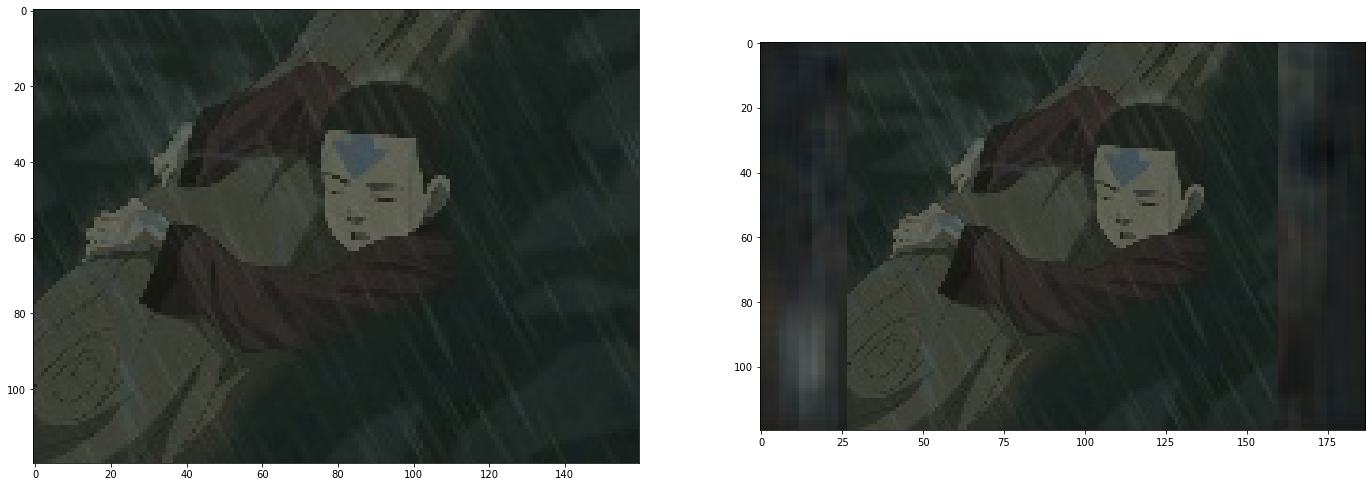

In [44]:
random_names = os.listdir(data_dir+'X')
image_name = random_names[random.randint(0, len(random_names))]
image_x = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)
image_y_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'Y', image_name)), dtype=float)
image_y_pred = autoencoder.predict(np.expand_dims(image_x, 0))[0]
image_y_pred_flip = np.flip(autoencoder.predict(np.expand_dims(np.flip(image_x, axis=1), 0))[0], axis=1)
image_true = np.concatenate((image_x, image_y_true), axis=1)
image_pred = np.concatenate((image_x, image_y_pred), axis=1)
image_pred = np.concatenate((image_y_pred_flip, image_pred), axis=1)
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_true)
ax = plt.subplot(10, 10, 2)
plt.imshow(image_pred)